In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as st

matplotlib. rcParams['font.family']='SimHei'
matplotlib.rcParams['axes.unicode_minus'] =False

In [2]:
df=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\sh300.xlsx',index_col='date')
daily_return=np.log(df).diff().dropna()

## Simple Historical Simulation

In [3]:
SHS_100=daily_return.rolling(100).apply(lambda x:np.quantile(x,0.05)).shift(periods=1)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


E:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


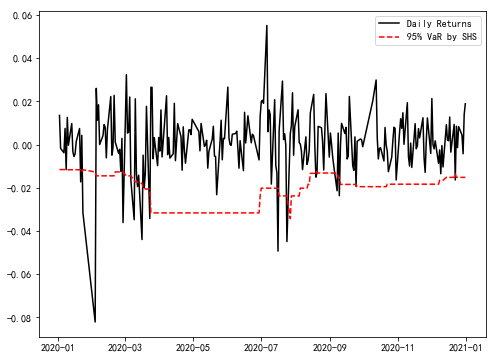

In [4]:
fig,ax=plt.subplots(figsize=(8, 6))

ax.plot(daily_return.loc['2020'].index,daily_return.loc['2020'],color='k',label='Daily Returns')
ax.plot(SHS_100.loc['2020'].index,SHS_100.loc['2020'],color='r',linestyle='--',label='95% VaR by SHS')
ax.legend()
plt.show()

## Weighted Historical Simulation

In [5]:
def WHS_func(array,k=0.98,VaR_level=0.05):
    num=len(array)
    
    weight_raw=np.array([k**(num-1-ii) for ii in range(num)])
    weight_sum=(1-k**num)/(1-k)
    weight=weight_raw/weight_sum
    
    array_sorted=np.sort(array)
    sort_order=np.argsort(array)
    weight_sorted=weight[sort_order]
    weight_cumsum=weight_sorted.cumsum()
    
    index_array=np.arange(num)
    index_temp=(weight_cumsum<VaR_level)
    
    if sum(index_temp):
        index_lower_bound=index_array[index_temp].max()
        index_upper_bound=index_array[~index_temp].min()

        slope=(array_sorted[index_upper_bound]-array_sorted[index_lower_bound])/(weight_cumsum[index_upper_bound]-weight_cumsum[index_lower_bound])

        return slope*(VaR_level-weight_cumsum[index_lower_bound])+array_sorted[index_lower_bound]
    else:
        return array_sorted[0]

In [6]:
WHS_100=daily_return.rolling(100).apply(WHS_func).shift(periods=1)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


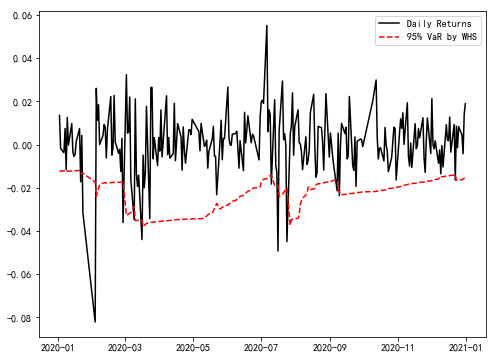

In [7]:
fig,ax=plt.subplots(figsize=(8, 6))

ax.plot(daily_return.loc['2020'].index,daily_return.loc['2020'],color='k',label='Daily Returns')
ax.plot(WHS_100.loc['2020'].index,WHS_100.loc['2020'],color='r',linestyle='--',label='95% VaR by WHS')
ax.legend()
plt.show()

## Risk Metrics

In [8]:
return_array=daily_return.to_numpy()
num=len(return_array)
sigma_square_array=np.zeros(num)

sigma_square_array[0]=return_array[0]**2

for ii in range(1,num):
    sigma_square_array[ii]=sigma_square_array[ii-1]*0.94+(return_array[ii]**2)*0.06
    
RM=pd.Series((sigma_square_array**0.5)*(-1.645),index=daily_return.index)
RM=RM.shift(periods=1)

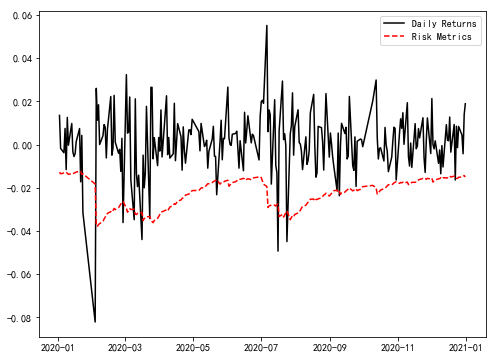

In [12]:
fig,ax=plt.subplots(figsize=(8, 6))

ax.plot(daily_return.loc['2020'].index,daily_return.loc['2020'],color='k',label='Daily Returns')
ax.plot(RM.loc['2020'].index,RM.loc['2020'],color='r',linestyle='--',label='Risk Metrics')
ax.legend()
plt.show()

In [23]:
# save the data

RM_2020=pd.DataFrame(RM.loc['2020'])
RM_2020.columns=['RM']

SHS_2020=SHS_100.loc['2020']
SHS_2020.columns=['SHS']

WHS_2020=WHS_100.loc['2020']
WHS_2020.columns=['WHS']

VaR_other=pd.concat([-SHS_2020,-WHS_2020,-RM_2020],axis=1)
VaR_other.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Other VaR Measures.xlsx',encoding='utf-8',index=True,header=True)